<a href="https://colab.research.google.com/github/MahaleVivek/PracticeNLP/blob/main/semantic_movie_search_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df_movies = pd.read_csv('/content/MoviesTopRated.csv')
df_movies.head()

,Unnamed: 0,id,genre_ids,title,overview,popularity,release_date,vote_average,vote_count
0,0,238,"[18, 80]",The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",119.438,1972-03-14,8.7,18448
1,1,278,"[18, 80]",The Shawshank Redemption,Framed in the 1940s for the double murder of h...,90.415,1994-09-23,8.7,24376
2,2,240,"[18, 80]",The Godfather Part II,In the continuing saga of the Corleone crime f...,70.637,1974-12-20,8.6,11144
3,3,424,"[18, 36, 10752]",Schindler's List,The true story of how businessman Oskar Schind...,48.096,1993-12-15,8.6,14421
4,4,19404,"[35, 18, 10749]",Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",26.588,1995-10-20,8.6,4225


In [ ]:
##Data Cleaning and Pre-processing

from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
import re
import spacy
import string

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

In [ ]:
def spacy_tokenizer(sentence):
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)

    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    #creating token object
    tokens = spacy_nlp(sentence)

    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]

    return tokens

In [ ]:
print(df_movies['overview'].dtype)

object


In [ ]:
df_movies['overview'] = df_movies['overview'].astype(str)

In [ ]:
type(df_movies['overview'])

pandas.core.series.Series

In [ ]:
# data-cleaning and pre-processing function to our movies “overview” column
# and store the cleaned, tokenized data into new column
#kind of stemming

In [ ]:
%time
print ('Cleaning and Tokenizing...')
df_movies['overview_tokenized'] = df_movies['overview'].map(lambda x: spacy_tokenizer(x))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
Cleaning and Tokenizing...


In [ ]:
movie_plot = df_movies['overview_tokenized']

df_movies.head()

,Unnamed: 0,id,genre_ids,title,overview,popularity,release_date,vote_average,vote_count,overview_tokenized
0,0,238,"[18, 80]",The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",119.438,1972-03-14,8.7,18448,"[span, year, chronicle, fictional, italian, am..."
1,1,278,"[18, 80]",The Shawshank Redemption,Framed in the 1940s for the double murder of h...,90.415,1994-09-23,8.7,24376,"[frame, double, murder, wife, lover, upstande,..."
2,2,240,"[18, 80]",The Godfather Part II,In the continuing saga of the Corleone crime f...,70.637,1974-12-20,8.6,11144,"[continue, saga, corleone, crime, family, youn..."
3,3,424,"[18, 36, 10752]",Schindler's List,The true story of how businessman Oskar Schind...,48.096,1993-12-15,8.6,14421,"[true, story, businessman, oskar, schindler, s..."
4,4,19404,"[35, 18, 10749]",Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",26.588,1995-10-20,8.6,4225,"[raj, rich, carefree, happy, lucky, second, ge..."


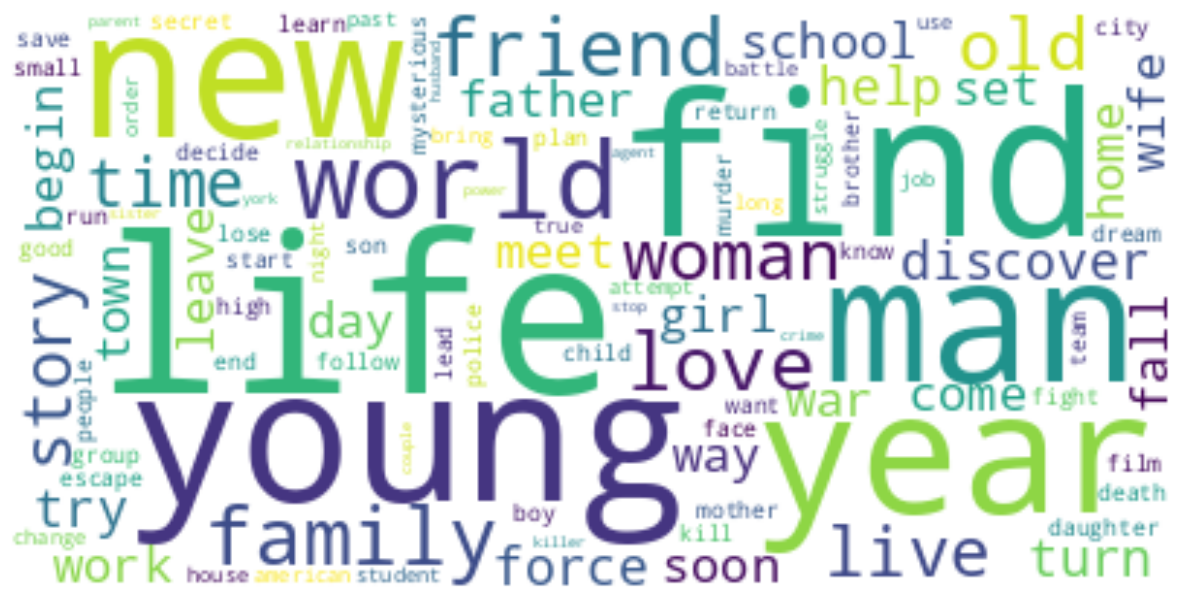

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np


series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Building Word Dictionary
# vocabulary of the corpus in which all the unique words are given IDs and their frequency counts

In [ ]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

CPU times: user 745 ms, sys: 2.95 ms, total: 748 ms
Wall time: 771 ms


In [ ]:
#Feature Extraction (Bag of Words)


#way of extracting features from text for use in modelling, such as with ML, it represents occurance of words

In [ ]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

In [ ]:
#The doc2bow method of dictionary, iterates through all the words in the text,
#if the word already exists in the corpus, it increments the frequency count,
#other wise it inserts the word into the corpus and sets it freqeuncy count to 1

corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

word_frequencies

[[('american', 1),
  ('attempt', 1),
  ('barely', 1),
  ('bloody', 1),
  ('campaign', 1),
  ('care', 1),
  ('chronicle', 1),
  ('corleone', 2),
  ('crime', 2),
  ('family', 2),
  ('fictional', 1),
  ('italian', 1),
  ('killer', 1),
  ('launch', 1),
  ('life', 1),
  ('michael', 1),
  ('organize', 1),
  ('patriarch', 1),
  ('revenge', 1),
  ('son', 1),
  ('span', 1),
  ('steps', 1),
  ('survive', 1),
  ('vito', 1),
  ('year', 1),
  ('young', 1)],
 [('life', 1),
  ('accounting', 1),
  ('admire', 1),
  ('amoral', 1),
  ('andy', 1),
  ('banker', 1),
  ('begin', 1),
  ('come', 1),
  ('double', 1),
  ('dufresne', 2),
  ('frame', 1),
  ('hope', 1),
  ('include', 1),
  ('inmate', 1),
  ('integrity', 1),
  ('long', 1),
  ('lover', 1),
  ('murder', 1),
  ('new', 1),
  ('old', 1),
  ('prison', 2),
  ('prisoner', 1),
  ('red', 1),
  ('sense', 1),
  ('shawshank', 1),
  ('skill', 1),
  ('stretch', 1),
  ('unquenchable', 1),
  ('upstande', 1),
  ('warden', 1),
  ('wife', 1),
  ('work', 1)],
 [('attemp

In [ ]:
#Building Tf-Idf and LSI Model
import gensim

movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

In [ ]:
#Serialize and Store the corpus locally for easy retrival whenver required.
gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

In [ ]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

In [ ]:
#Load the MatrixSimilarity


from gensim.similarities import MatrixSimilarity
movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

In [ ]:
#Time for Semantic Search

In [ ]:
from operator import itemgetter

In [ ]:
def search_similar_movies(search_term):
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['overview'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

In [ ]:
search_similar_movies('crime and drugs ')

,Relevance,Movie Title,Movie Plot
0,62.10,Get Rich or Die Tryin',A tale of an inner city drug dealer who turns ...
1,62.05,Scarface,After getting a green card in exchange for ass...
2,61.21,Twelve,A young drug dealer watches as his high-rollin...
3,60.74,The Death and Life of Bobby Z,A DEA agent provides former Marine Tim Kearney...
4,57.25,Marked for Death,"Just retired from the Drug Enforcement Agency,..."


In [ ]:
search_similar_movies('crime batman')

,Relevance,Movie Title,Movie Plot
0,69.65,Joker,"During the 1980s, a failed stand-up comedian i..."
1,60.04,The Dark Knight,Batman raises the stakes in his war on crime. ...
2,57.20,"Batman: The Dark Knight Returns, Part 1",Batman has not been seen for ten years. A new ...
3,57.02,Batman: The Killing Joke,"As Batman hunts for the escaped Joker, the Clo..."
4,56.40,Batman: Mask of the Phantasm,"When a powerful criminal, who is connected to ..."


In [ ]:
search_similar_movies('violence protest march')

,Relevance,Movie Title,Movie Plot
0,47.22,A Touch of Sin,Four independent stories set in modern China a...
1,42.66,The Nightingale,"In 1825, Clare, a 21-year-old Irish convict, c..."
2,40.92,Selma,"""Selma,"" as in Alabama, the place where segreg..."
3,36.90,Green Room,A punk rock band becomes trapped in a secluded...
4,36.60,Raging Bull,"The life of boxer Jake LaMotta, whose violence..."


In [ ]:
search_similar_movies('love affair hate')

,Relevance,Movie Title,Movie Plot
0,67.48,Fast Food Nation,A dramatised examination of the health issues ...
1,60.12,Mary Shelley,The love affair between poet Percy Shelley and...
2,57.64,Lady Chatterley's Lover,Unhappily married aristocrat Lady Chatterley b...
3,55.74,Loving Adults,The thin line between love and hate turns dead...
4,55.59,The Deep Blue Sea,The wife of a British Judge is caught in a sel...


In [ ]:
search_similar_movies('food')

,Relevance,Movie Title,Movie Plot
0,53.05,Good Burger,Two hapless youths lead their burger joint in ...
1,49.98,The Wing or the Thigh?,"Charles Duchemin, a well-known gourmet and pub..."
2,48.43,Cloudy with a Chance of Meatballs,Inventor Flint Lockwood creates a machine that...
3,47.05,Fast Food Nation,A dramatised examination of the health issues ...
4,45.71,Small Fry,A fast food restaurant mini variant of Buzz fo...


In [ ]:
search_similar_movies('hollywood')

,Relevance,Movie Title,Movie Plot
0,64.89,Sunset Boulevard,A hack screenwriter writes a screenplay for a ...
1,58.18,"Hail, Caesar!",When a Hollywood star mysteriously disappears ...
2,57.94,The Muppet Movie,A Hollywood agent persuades Kermit the Frog to...
3,54.98,Get Shorty,Chili Palmer is a Miami mobster who gets sent ...
4,53.44,Singin' in the Rain,"In 1927 Hollywood, a silent film production co..."


In [ ]:
search_similar_movies('vegas hollywood')

,Relevance,Movie Title,Movie Plot
0,56.76,Sunset Boulevard,A hack screenwriter writes a screenplay for a ...
1,51.83,The Muppet Movie,A Hollywood agent persuades Kermit the Frog to...
2,50.10,"Hail, Caesar!",When a Hollywood star mysteriously disappears ...
3,48.95,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr..."
4,48.49,Get Shorty,Chili Palmer is a Miami mobster who gets sent ...


In [ ]:
search_similar_movies('indian')

,Relevance,Movie Title,Movie Plot
0,53.14,The Indian in the Cupboard,A nine-year-old boy gets a plastic Indian and ...
1,46.50,A Passage to India,Set during the period of growing influence of ...
2,43.92,Slumdog Millionaire,A teenager reflects on his life after being ac...
3,40.56,The Hundred-Foot Journey,A story centered around an Indian family who m...
4,39.49,Swades,A successful Indian scientist returns home to ...
